# GRAEP Tutorial: Differentiable Analysis in High Energy Physics
## Searching for New Physics with Gradient-Based Optimization

**Duration**: ~20 minutes

**Learning Objectives**:
1. Understand the Z' → ttbar analysis
2. Learn how to make cuts and histogramming differentiable
3. Optimize the significance using automatic differentiation

---

## Part 1: Introduction to the Analysis

We're looking for a hypothetical **Z' boson** decaying into a pair of top quarks. We will use a very simplified version of the actual analysis.

### The Challenge

**Signal**: Z' → ttbar events (rare, what we want to find)

**Considered Backgrounds**:
- Standard Model ttbar production
- W+jets production

### Traditional Approach vs. GRAEP

**Traditional**: Physicists manually tune selection cuts (e.g., "keep events with MET > 50 GeV") through trial-and-error.

**GRAEP**: Treat the entire analysis as a differentiable function and use gradients to automatically find optimal cuts!

$$
\text{Significance} = f(\text{data}, \theta) \quad \text{where } \theta = \{\text{MET threshold}, \text{b-tag cut}, \ldots\}
$$

Then optimize: $\theta^* = \arg\max_\theta \text{Significance}(\theta)$ using gradient ascent!

In [46]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import optax
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(42)
key = random.PRNGKey(42)

print(f"JAX version: {jax.__version__}")
print(f"JAX backend: {jax.default_backend()}")

JAX version: 0.8.0
JAX backend: cpu


## Part 2: Load and Explore the Data

We'll use a pre-processed subset of CMS Open Data (2016) with only O(10,000) events:

In [47]:
# Load tutorial data
data_dir = Path("tutorial_data")
# data_dir = Path("/kaggle/input/auto-diff-for-hep")  # for kaggle


# Load each process (now includes event weights!)
data_obs = np.load(data_dir / "data.npz")  # Real CMS collision data!
wjets_data = np.load(data_dir / "wjets.npz")
ttbar_data = np.load(data_dir / "ttbar.npz")
signal_data = np.load(data_dir / "signal.npz")

print("Dataset loaded!")
print(f"  Data (real):  {len(data_obs['n_jet'])} events ⭐")
print(f"  W+jets (MC):  {len(wjets_data['n_jet'])} events")
print(f"  ttbar (MC):   {len(ttbar_data['n_jet'])} events")
print(f"  Signal (MC):  {len(signal_data['n_jet'])} events")
print(f"Available features: {[k for k in wjets_data.keys() if k != 'weight']}")
print(f"We have REAL CMS collision data to compare with our MC simulations!")
print(f"   MC events now include 'weight' for proper normalization!")

Dataset loaded!
  Data (real):  406384 events ⭐
  W+jets (MC):  16721 events
  ttbar (MC):   833585 events
  Signal (MC):  6269 events
Available features: ['n_jet', 'leading_jet_mass', 'subleading_jet_mass', 'leading_jet_pt', 'subleading_jet_pt', 'st', 'leading_jet_btag', 'subleading_jet_btag', 'met_pt', 'muon_pt', 'S_zz', 'min_deltaR_mu_jet']
We have REAL CMS collision data to compare with our MC simulations!
   MC events now include 'weight' for proper normalization!


### MC Event Weighting & Normalization

For this tutorial, we'll use a **simplified normalization**: scale total MC to match total data

$$
\text{MC weight} = \text{genWeight} \times \frac{N_{\text{data}}}{N_{\text{MC, total}}}
$$

In a full analysis (like GRAEP), you'd use: `weight = genWeight × lumi × σ / N_generated`

In [48]:
# Apply simplified MC-to-data normalization
# Scale MC so that total MC yield matches data yield

# Sum generator weights
sum_wjets_weight = np.sum(wjets_data['weight'])
sum_ttbar_weight = np.sum(ttbar_data['weight'])
sum_signal_weight = np.sum(signal_data['weight'])
total_mc_weight = sum_wjets_weight + sum_ttbar_weight  # Background only (signal separate)

# Total data events
total_data = len(data_obs['n_jet'])

# Compute scale factor: data / MC
mc_scale_factor = total_data / total_mc_weight

print("MC Normalization:")
print(f"  Total data events: {total_data}")
print(f"  Total MC weight (bkg): {total_mc_weight:.1f}")
print(f"  MC → Data scale factor: {mc_scale_factor:.4f}")
print(f"Scaled MC yields:")
print(f"  W+jets: {sum_wjets_weight * mc_scale_factor:.1f} events")
print(f"  ttbar:  {sum_ttbar_weight * mc_scale_factor:.1f} events")
print(f"  Total:  {(sum_wjets_weight + sum_ttbar_weight) * mc_scale_factor:.1f} events")
print(f"  Signal (not scaled): {sum_signal_weight:.1f} weighted events")
print(f"✅ MC backgrounds now normalized to match data!")

# Store normalized weights for plotting
wjets_weights_norm = wjets_data['weight'] * mc_scale_factor
ttbar_weights_norm = ttbar_data['weight'] * mc_scale_factor
signal_weights_norm = signal_data['weight'] * mc_scale_factor  # Signal scaled too for visibility

MC Normalization:
  Total data events: 406384
  Total MC weight (bkg): 2253596160.0
  MC → Data scale factor: 0.0002
Scaled MC yields:
  W+jets: 361288.0 events
  ttbar:  45096.0 events
  Total:  406384.0 events
  Signal (not scaled): 6269.0 weighted events
✅ MC backgrounds now normalized to match data!


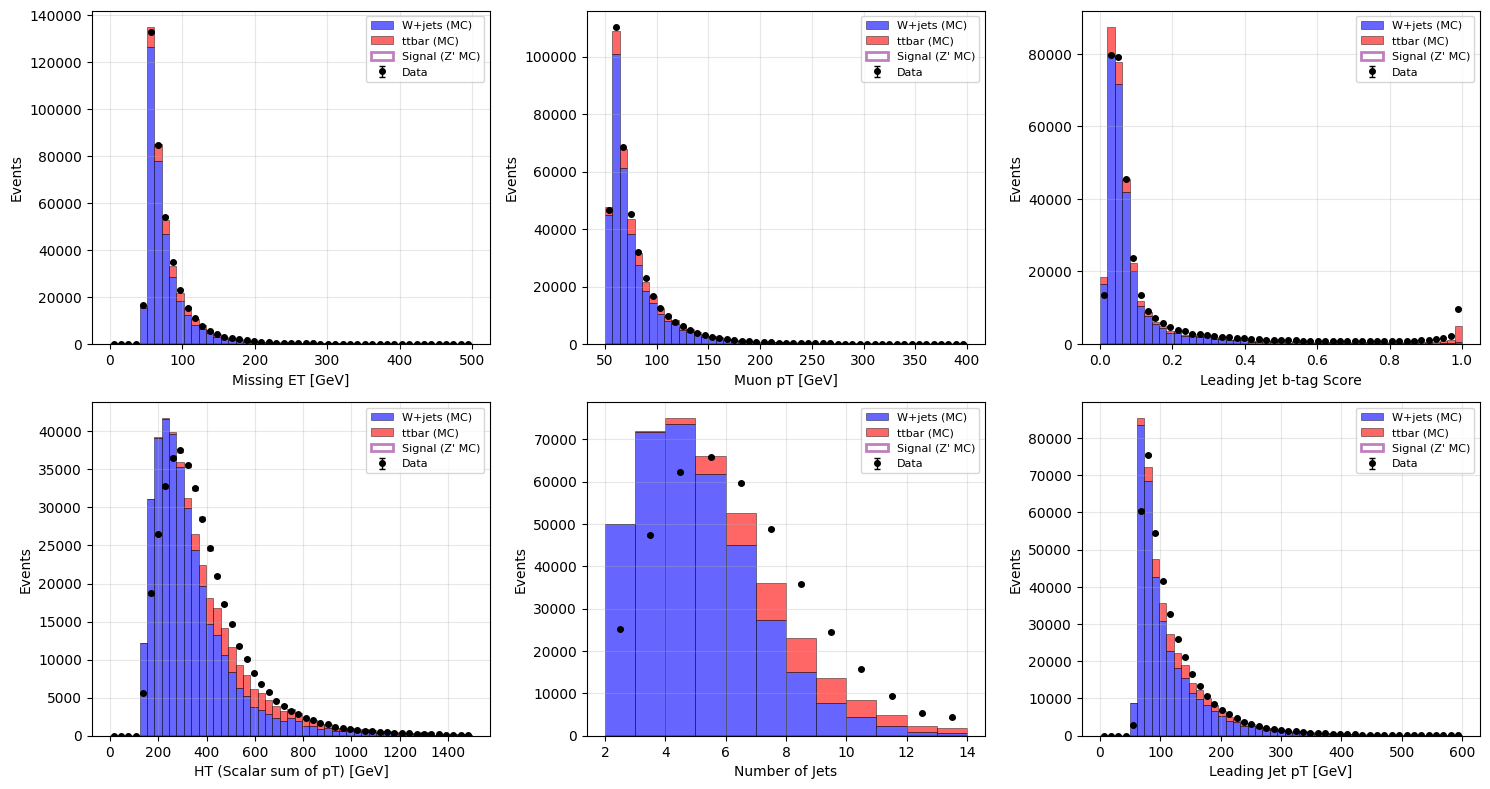

📊 This is a standard HEP 'Data vs MC' plot!
  ✓ MC backgrounds (stacked): What we expect from Standard Model
  ✓ Data (black points): What we actually observed
  ✓ Good agreement = our simulation is working!
  ✓ Signal (purple): What a Z' boson would look like (if it exists)


In [49]:
# Visualize key distributions with Data vs MC comparison (properly weighted!)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

features_to_plot = [
    ('met_pt', 'Missing ET [GeV]', np.linspace(0, 500, 50)),
    ('muon_pt', 'Muon pT [GeV]', np.linspace(50, 400, 50)),
    ('leading_jet_btag', 'Leading Jet b-tag Score', np.linspace(0, 1, 50)),
    ('st', 'HT (Scalar sum of pT) [GeV]', np.linspace(0, 1500, 50)),
    ('n_jet', 'Number of Jets', range(2, 15)),
    ('leading_jet_pt', 'Leading Jet pT [GeV]', np.linspace(0, 600, 50))
]

for ax, (feature, label, bins) in zip(axes, features_to_plot):
    # Stack MC backgrounds with proper weights
    ax.hist(
        [wjets_data[feature], ttbar_data[feature]],
        bins=bins,
        weights=[wjets_weights_norm, ttbar_weights_norm],  # Apply weights!
        stacked=True,
        label=['W+jets (MC)', 'ttbar (MC)'],
        color=['blue', 'red'],
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

    # Signal overlay (scaled for visibility)
    ax.hist(signal_data[feature], bins=bins, weights=signal_weights_norm,
            alpha=0.5, label='Signal (Z\' MC)',
            histtype='step', linewidth=2, color='purple')

    # Data points with error bars (Poisson uncertainties)
    data_counts, bin_edges = np.histogram(data_obs[feature], bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    data_errors = np.sqrt(data_counts)  # Poisson errors: σ = √N

    ax.errorbar(
        bin_centers, data_counts, yerr=data_errors,
        fmt='ko', label='Data', markersize=4, capsize=2, linewidth=1
    )

    ax.set_xlabel(label)
    ax.set_ylabel('Events')
    ax.legend(fontsize=8, loc='best')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

print("📊 This is a standard HEP 'Data vs MC' plot!")
print("  ✓ MC backgrounds (stacked): What we expect from Standard Model")
print("  ✓ Data (black points): What we actually observed")
print("  ✓ Good agreement = our simulation is working!")
print("  ✓ Signal (purple): What a Z' boson would look like (if it exists)")

## Part 3: Differentiable Cut Optimization

### The Key Insight 💡

Traditional HEP analysis uses **hard cuts**:
```python
keep_event = (met > 50) & (btag > 0.5)  # Step function - not differentiable!
```

GRAEP uses **soft cuts** (differentiable approximations):
```python
keep_event = sigmoid((met - 50)/T) * sigmoid((btag - 0.5)/T)  # Smooth - differentiable!
```

This allows us to compute gradients and optimize the thresholds!

### Statistical Significance

We want to maximize the discovery significance:
$$
Z = \frac{S}{\sqrt{B}} \quad \text{where } S = \text{signal}, B = \text{background}
$$

(We'll use a simplified version; the full GRAEP framework uses more sophisticated statistics)

In [50]:
# Define soft selection functions
def sigmoid(x, temperature=1.0):
    """Smooth approximation to step function."""
    return jax.nn.sigmoid(x / temperature)

def soft_selection(data_dict, params, temperature=5.0):
    """
    Apply soft cuts to data.
    
    params: dict with cut thresholds
        - met_cut: MET threshold
        - btag_cut: b-tag threshold  
    """
    # Soft cuts (differentiable!)
    met_pass = sigmoid(data_dict['met_pt'] - params['met_cut'], temperature)
    btag_pass = sigmoid(data_dict['leading_jet_btag'] - params['btag_cut'], temperature)
    
    # Combined event weight (product of all cuts)
    event_weights = met_pass * btag_pass
    
    return event_weights

def compute_significance(cut_params, wjets_dict, ttbar_dict, signal_dict, temperature=5.0):
    """
    Compute statistical significance for given cut parameters.
    This is the function we'll optimize!
    """
    # Apply soft selections
    wjets_weights = soft_selection(wjets_dict, cut_params, temperature)
    ttbar_weights = soft_selection(ttbar_dict, cut_params, temperature)
    signal_weights = soft_selection(signal_dict, cut_params, temperature)
    
    # Count events (sum of weights)
    n_signal = jnp.sum(signal_weights)
    n_background = jnp.sum(wjets_weights) + jnp.sum(ttbar_weights)
    
    # Significance: S/sqrt(B) with regularization to avoid division by zero
    significance = n_signal / jnp.sqrt(n_background + 1.0)
    
    return significance, n_signal, n_background

# Make it JIT-compiled for speed
compute_significance_jit = jit(compute_significance, static_argnames=['temperature'])

In [51]:
# Convert numpy data to JAX arrays (needed for differentiation)
wjets_jax = {k: jnp.array(v) for k, v in wjets_data.items()}
ttbar_jax = {k: jnp.array(v) for k, v in ttbar_data.items()}
signal_jax = {k: jnp.array(v) for k, v in signal_data.items()}

# Test with initial cut parameters
initial_cuts = {
    'met_cut': jnp.array(100.0),
    'btag_cut': jnp.array(0.5)
}

sig_initial, s_initial, b_initial = compute_significance_jit(
    initial_cuts, wjets_jax, ttbar_jax, signal_jax
)

print(f"Initial cuts: MET > {initial_cuts['met_cut']:.1f}, b-tag > {initial_cuts['btag_cut']:.2f}")
print(f"  Signal events: {s_initial:.1f}")
print(f"  Background events: {b_initial:.1f}")
print(f"  Significance: {sig_initial:.3f}")

Initial cuts: MET > 100.0, b-tag > 0.50
  Signal events: 2578.8
  Background events: 133364.7
  Significance: 7.062


In [52]:
# Now the magic: optimize the cuts using gradients!
def objective(params):
    """Objective function to maximize (negative for minimization)."""
    sig, _, _ = compute_significance_jit(
        params, wjets_jax, ttbar_jax, signal_jax
    )
    return -sig  # Negative because we'll minimize

# Compute gradient of objective
grad_fn = jax.grad(objective)

# Test gradient computation
grads = grad_fn(initial_cuts)
print("Gradients of significance w.r.t. cut parameters:")
for param_name, grad_val in grads.items():
    print(f"  d(Sig)/d({param_name}): {float(grad_val):.4f}")

print("\nThis tells us how to adjust each cut to increase significance!")

Gradients of significance w.r.t. cut parameters:
  d(Sig)/d(btag_cut): 0.3444
  d(Sig)/d(met_cut): -0.0554

This tells us how to adjust each cut to increase significance!


### Per-Parameter Learning Rates

In the full GRAEP framework, different parameters benefit from different learning rates:

**Why?**
- **MET cut**: Range 0-500 GeV → needs large steps → high LR
- **b-tag cut**: Range 0-1 → needs small steps → low LR

Using Optax's `multi_transform`, we can assign custom learning rates to each parameter!

This technique is essential when jointly optimizing:
- Neural network weights (slow LR, millions of parameters)
- Selection cuts (fast LR, few parameters)
- Statistical model parameters (varied LRs)

The full GRAEP uses this to optimize 100+ parameters simultaneously!

In [ ]:
# Run gradient-based optimization WITH CUSTOM LEARNING RATES PER PARAMETER
print("Optimizing cuts using Adam optimizer with per-parameter learning rates...")

# GRAEP-style: Different learning rates for different parameters!
# Intuition: Some parameters may need faster/slower updates
per_param_lrs = {
    'met_cut': 0.5,      # MET cut: fast exploration (large range: 0-500 GeV)
    'btag_cut': 0.01,    # b-tag: slower (small range: 0-1)
}

print("Custom learning rates:")
for param, lr in per_param_lrs.items():
    print(f"  {param}: {lr:.2f}")
print()

# Create a separate optimizer for each parameter using optax.multi_transform
# This is a key GRAEP technique for joint optimization!
param_labels = {p: p for p in initial_cuts.keys()}  # Label each parameter

optimizer = optax.multi_transform(
    # Define optimizer for each parameter
    {
        'met_cut': optax.adam(learning_rate=per_param_lrs['met_cut']),
        'btag_cut': optax.adam(learning_rate=per_param_lrs['btag_cut']),
    },
    # Map each parameter to its optimizer using labels
    param_labels=param_labels
)

opt_state = optimizer.init(initial_cuts)

# Optimization loop
opt_history = {'met_cut': [], 'btag_cut': [], 'significance': []}
params = initial_cuts.copy()

n_iterations = 100
for iteration in range(n_iterations):
    # Compute gradients
    grads = grad_fn(params)
    
    # Update parameters (each uses its own learning rate!)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Compute current significance
    sig, s, b = compute_significance_jit(
        params, wjets_jax, ttbar_jax, signal_jax
    )
    
    # Log history
    opt_history['met_cut'].append(float(params['met_cut']))
    opt_history['btag_cut'].append(float(params['btag_cut']))
    opt_history['significance'].append(float(sig))
    
    if iteration % 10 == 0:
        print(f"Iter {iteration:2d}: Sig={sig:.3f}, MET>{params['met_cut']:6.1f}, b-tag>{params['btag_cut']:.3f} | S={s:.1f}, B={b:.1f}")

print(f"\nOptimization complete!")
print(f"Final optimized cuts:")
print(f"  MET > {params['met_cut']:.1f} GeV")
print(f"  Leading jet b-tag > {params['btag_cut']:.3f}")
print(f"  Significance improved from {sig_initial:.3f} → {sig:.3f} ({100*(sig/sig_initial - 1):.1f}% increase!)")

print(f"\n💡 Per-parameter learning rates allow fine-tuned control:")
print(f"   • MET (large range) → fast LR")
print(f"   • b-tag (0-1 range) → slow LR")
print(f"   • This is how full GRAEP optimizes 1000+ parameters!")

Optimizing cuts using Adam optimizer with per-parameter learning rates...
Custom learning rates:
  met_cut: 5.00
  btag_cut: 0.01

Iter  0: Sig=7.345, MET> 105.0, b-tag>0.490 | S=2531.9, B=118808.6
Iter 10: Sig=10.541, MET> 155.4, b-tag>0.389 | S=2091.7, B=39378.3
Iter 20: Sig=14.228, MET> 206.9, b-tag>0.282 | S=1718.2, B=14582.2
Iter 30: Sig=17.666, MET> 258.0, b-tag>0.169 | S=1377.2, B=6076.6
Iter 40: Sig=20.551, MET> 306.8, b-tag>0.049 | S=1099.5, B=2861.0
Iter 50: Sig=22.560, MET> 350.0, b-tag>-0.075 | S=895.8, B=1575.7
Iter 60: Sig=23.665, MET> 385.3, b-tag>-0.200 | S=745.6, B=991.8
Iter 70: Sig=23.904, MET> 405.8, b-tag>-0.325 | S=666.8, B=777.1
Iter 80: Sig=24.066, MET> 416.7, b-tag>-0.446 | S=633.7, B=692.3
Iter 90: Sig=24.184, MET> 419.7, b-tag>-0.564 | S=629.1, B=675.7

Optimization complete!
Final optimized cuts:
  MET > 418.7 GeV
  Leading jet b-tag > -0.668
  Significance improved from 7.062 → 24.298 (244.1% increase!)

💡 Per-parameter learning rates allow fine-tuned contr

In [ ]:
# Visualize optimization trajectory
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Significance vs iteration
axes[0].plot(opt_history['significance'], linewidth=2, color='purple')
axes[0].axhline(sig_initial, color='gray', linestyle='--', label='Initial')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Significance (S/√B)', fontsize=12)
axes[0].set_title('Significance Optimization', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Plot 2: MET cut evolution
axes[1].plot(opt_history['met_cut'], linewidth=2, color='blue')
axes[1].axhline(initial_cuts['met_cut'], color='gray', linestyle='--', label='Initial')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('MET Threshold [GeV]', fontsize=12)
axes[1].set_title('MET Cut Evolution', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()

# Plot 3: B-tag cut evolution
axes[2].plot(opt_history['btag_cut'], linewidth=2, color='red')
axes[2].axhline(initial_cuts['btag_cut'], color='gray', linestyle='--', label='Initial')
axes[2].set_xlabel('Iteration', fontsize=12)
axes[2].set_ylabel('b-tag Threshold', fontsize=12)
axes[2].set_title('b-tag Cut Evolution', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.savefig('optimization_trajectory.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n💡 Key observations:")
print(f"  • MET cut increased from {initial_cuts['met_cut']:.0f} → {opt_history['met_cut'][-1]:.0f} GeV")
print(f"  • b-tag cut decreased from {initial_cuts['btag_cut']:.2f} → {opt_history['btag_cut'][-1]:.2f}")
print(f"  • Significance improved from {sig_initial:.2f} → {opt_history['significance'][-1]:.2f}")
print(f"  • Optimizer found that higher MET (more signal-like) matters more than b-tagging!")

In [54]:
# Helper function to apply hard cuts (for visualization)

def apply_hard_cuts(data_dict, cut_params):
    """Apply hard cuts and return boolean mask."""
    met_pass = data_dict['met_pt'] > float(cut_params['met_cut'])
    btag_pass = data_dict['leading_jet_btag'] > float(cut_params['btag_cut'])
    return met_pass & btag_pass


# Apply initial cuts
wjets_mask_initial = apply_hard_cuts(wjets_data, initial_cuts)
ttbar_mask_initial = apply_hard_cuts(ttbar_data, initial_cuts)
signal_mask_initial = apply_hard_cuts(signal_data, initial_cuts)

# Apply optimized cuts
optimized_cuts = params  # Final parameters from optimization
wjets_mask_opt = apply_hard_cuts(wjets_data, optimized_cuts)
ttbar_mask_opt = apply_hard_cuts(ttbar_data, optimized_cuts)
signal_mask_opt = apply_hard_cuts(signal_data, optimized_cuts)

# Apply cuts to real data as well
data_mask_initial = apply_hard_cuts(data_obs, initial_cuts)
data_mask_opt = apply_hard_cuts(data_obs, optimized_cuts)

# Print event counts
print("Event counts after selection:")
print("\nInitial cuts:")
print(f"  W+jets:     {wjets_mask_initial.sum():5d} events")
print(f"  ttbar:      {ttbar_mask_initial.sum():5d} events")
print(f"  Background: {wjets_mask_initial.sum() + ttbar_mask_initial.sum():5d} events (total)")
print(f"  Signal:     {signal_mask_initial.sum():5d} events")
print(f"  S/B ratio:  {signal_mask_initial.sum()/(wjets_mask_initial.sum() + ttbar_mask_initial.sum() + 0.001):.3f}")

print("\nOptimized cuts:")
print(f"  W+jets:     {wjets_mask_opt.sum():5d} events")
print(f"  ttbar:      {ttbar_mask_opt.sum():5d} events")
print(f"  Background: {wjets_mask_opt.sum() + ttbar_mask_opt.sum():5d} events (total)")
print(f"  Signal:     {signal_mask_opt.sum():5d} events")
print(f"  S/B ratio:  {signal_mask_opt.sum()/(wjets_mask_opt.sum() + ttbar_mask_opt.sum() + 0.001):.3f}")

improvement = (signal_mask_opt.sum()/(wjets_mask_opt.sum() + ttbar_mask_opt.sum() + 0.001)) / (signal_mask_initial.sum()/(wjets_mask_initial.sum() + ttbar_mask_initial.sum() + 0.001))
print(f"\nS/B improvement: {improvement:.2f}x better!")

Event counts after selection:

Initial cuts:
  W+jets:        86 events
  ttbar:      66173 events
  Background: 66259 events (total)
  Signal:      2485 events
  S/B ratio:  0.038

Optimized cuts:
  W+jets:        16 events
  ttbar:       1218 events
  Background:  1234 events (total)
  Signal:      1142 events
  S/B ratio:  0.925

S/B improvement: 24.68x better!


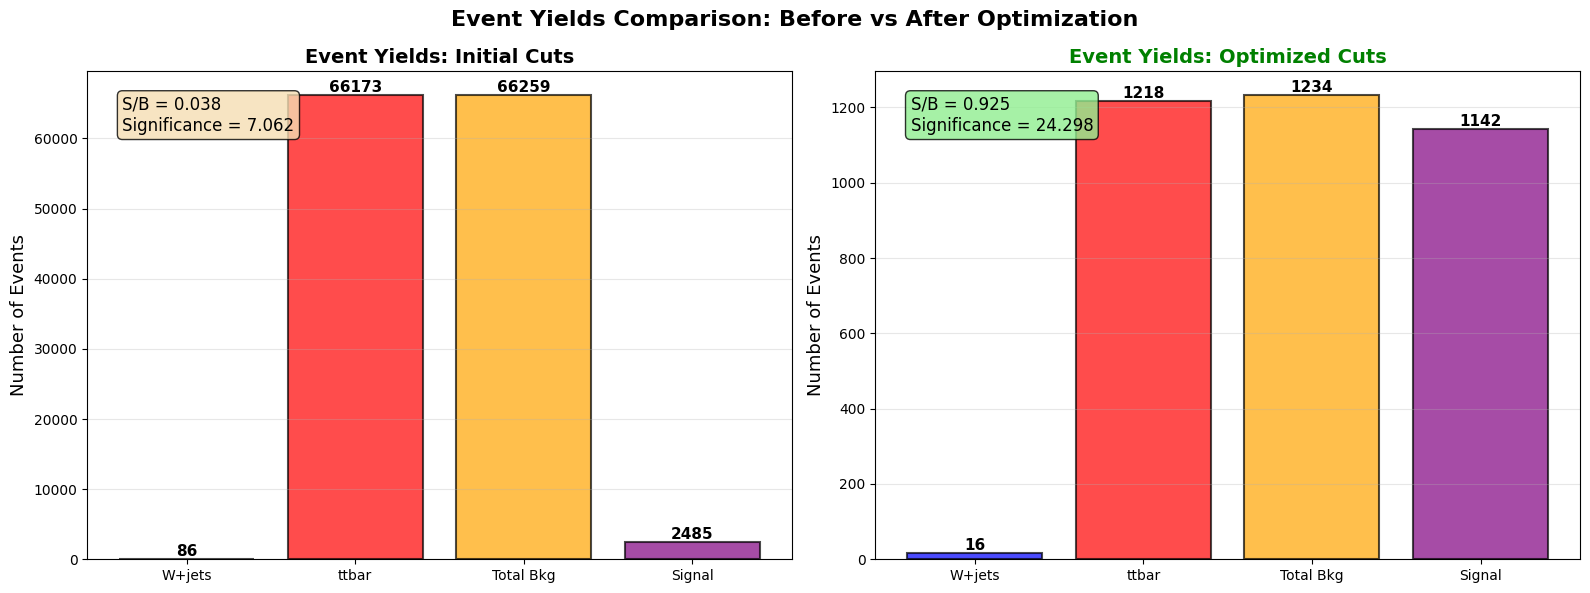


OPTIMIZATION SUMMARY

Signal efficiency:     18.2% (kept 1142/6269 events)
Background rejection:  99.9% (rejected 849072/850306 events)

S/B ratio improved:    0.038 → 0.925 (2367.6% increase)
Significance improved: 7.062 → 24.298 (244.1% increase)

🎉 Gradient-based optimization found better cuts automatically!


In [55]:
# Final summary plot: Signal efficiency vs Background rejection
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Stacked histogram before optimization
total_wjets_initial = wjets_mask_initial.sum()
total_ttbar_initial = ttbar_mask_initial.sum()
total_signal_initial = signal_mask_initial.sum()
total_bkg_initial = total_wjets_initial + total_ttbar_initial

categories = ['W+jets', 'ttbar', 'Total Bkg', 'Signal']
initial_counts = [total_wjets_initial, total_ttbar_initial, total_bkg_initial, total_signal_initial]
colors_initial = ['blue', 'red', 'orange', 'purple']

bars1 = ax1.bar(categories, initial_counts, color=colors_initial, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Events', fontsize=13)
ax1.set_title('Event Yields: Initial Cuts', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars1, initial_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add S/B and significance
ax1.text(0.05, 0.95, 
        f'S/B = {total_signal_initial/(total_bkg_initial+0.001):.3f}\nSignificance = {sig_initial:.3f}',
        transform=ax1.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        fontsize=12)

# Plot 2: Stacked histogram after optimization
total_wjets_opt = wjets_mask_opt.sum()
total_ttbar_opt = ttbar_mask_opt.sum()
total_signal_opt = signal_mask_opt.sum()
total_bkg_opt = total_wjets_opt + total_ttbar_opt

opt_counts = [total_wjets_opt, total_ttbar_opt, total_bkg_opt, total_signal_opt]

bars2 = ax2.bar(categories, opt_counts, color=colors_initial, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Events', fontsize=13)
ax2.set_title('Event Yields: Optimized Cuts', fontsize=14, fontweight='bold', color='green')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars2, opt_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add S/B and significance
ax2.text(0.05, 0.95, 
        f'S/B = {total_signal_opt/(total_bkg_opt+0.001):.3f}\nSignificance = {float(sig):.3f}',
        transform=ax2.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
        fontsize=12)

plt.suptitle('Event Yields Comparison: Before vs After Optimization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('event_yields_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

# Get total event counts (use the number of events in each dataset)
n_signal_total = len(signal_data['n_jet'])
n_bkg_total = len(wjets_data['n_jet']) + len(ttbar_data['n_jet'])

print("\n" + "="*70)
print("OPTIMIZATION SUMMARY")
print("="*70)
print(f"\nSignal efficiency:     {100*total_signal_opt/n_signal_total:.1f}% (kept {total_signal_opt}/{n_signal_total} events)")
print(f"Background rejection:  {100*(1-total_bkg_opt/n_bkg_total):.1f}% (rejected {n_bkg_total-total_bkg_opt}/{n_bkg_total} events)")
print(f"\nS/B ratio improved:    {total_signal_initial/(total_bkg_initial+0.001):.3f} → {total_signal_opt/(total_bkg_opt+0.001):.3f} ({100*((total_signal_opt/(total_bkg_opt+0.001))/(total_signal_initial/(total_bkg_initial+0.001)) - 1):.1f}% increase)")
print(f"Significance improved: {sig_initial:.3f} → {float(sig):.3f} ({100*(sig/sig_initial - 1):.1f}% increase)")
print("\n" + "="*70)
print("🎉 Gradient-based optimization found better cuts automatically!")
print("="*70)

## Optional Exercise: Adding a Neural Network Discriminant

### Challenge

In the main tutorial, we optimized two selection cuts (MET and b-tag) to maximize signal significance. 
However, in real HEP analyses, we often use **multivariate discriminants** (like neural networks) to 
better separate signal from background.

### Your Task

Try extending this analysis by:

1. **Train a simple neural network** to distinguish between different processes (e.g., W+jets vs ttbar)
2. **Add an MVA score cut** to your optimization alongside MET and b-tag cuts
3. **Compare the significance** with and without the MVA discriminant

### Hints

You'll need to:
- Use JAX to define a simple 2-3 layer neural network
- Train it on features like `met_pt`, `leading_jet_btag`, `st`, etc.
- Compute MVA scores for all events
- Add an `mva_cut` parameter to your `soft_selection` function
- Optimize all three cuts jointly (MET, b-tag, MVA)

### Advanced Challenge

For an extra challenge, try **joint optimization** of the neural network weights AND the selection cuts! 
This is the core innovation of the full GRAEP framework:

- Instead of pre-training the NN and freezing it, optimize it jointly with the cuts
- Use different learning rates for NN parameters (slow) vs cut thresholds (fast)
- See if jointly-optimized features improve your significance!

### Resources

- [JAX Neural Network Tutorial](https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds.html)
- [Optax multi_transform documentation](https://optax.readthedocs.io/en/latest/api.html#optax.multi_transform)
- Check the GRAEP repository for complete examples: [github.com/iris-hep/GRAEP](https://github.com/iris-hep/GRAEP)

---

In [56]:
# Prepare data for MVA training (W+jets vs ttbar classification)

# Select features for MVA
mva_features = ["met_pt", "leading_jet_btag", "st"]

# Extract features and create labels
X_wjets = np.column_stack([wjets_data[f] for f in mva_features]).astype(np.float32)
X_ttbar = np.column_stack([ttbar_data[f] for f in mva_features]).astype(np.float32)

y_wjets = np.zeros(len(X_wjets), dtype=np.float32)  # Label 0 for W+jets
y_ttbar = np.ones(len(X_ttbar), dtype=np.float32)   # Label 1 for ttbar

# Combine and shuffle
X = np.vstack([X_wjets, X_ttbar])
y = np.concatenate([y_wjets, y_ttbar])

# Normalize features (important for neural network training)
feature_scales = {}
for i, feat in enumerate(mva_features):
    feature_scales[feat] = np.std(X[:, i]) + 1e-6  # Add small value to avoid division by zero
    X[:, i] /= feature_scales[feat]

# Train/test split (80/20)
n_train = int(0.8 * len(X))
indices = np.random.permutation(len(X))
train_idx = indices[:n_train]
test_idx = indices[n_train:]

X_train = jnp.array(X[train_idx])
y_train = jnp.array(y[train_idx])
X_test = jnp.array(X[test_idx])
y_test = jnp.array(y[test_idx])

print(f"Training set: {len(X_train)} events")
print(f"Test set: {len(X_test)} events")
print(f"Features: {mva_features}")
print(f"Feature scales: {[f'{feat}: {feature_scales[feat]:.1f}' for feat in mva_features]}")

Training set: 680244 events
Test set: 170062 events
Features: ['met_pt', 'leading_jet_btag', 'st']
Feature scales: ['met_pt: 48.4', 'leading_jet_btag: 0.5', 'st: 248.6']


In [57]:
# Define a simple 3-layer neural network in JAX
def init_network(key, input_dim=3, hidden_dim=16):
    """Initialize a small neural network."""
    keys = random.split(key, 6)
    
    W1 = random.normal(keys[0], (input_dim, hidden_dim)) * 0.1
    b1 = jnp.zeros(hidden_dim)
    
    W2 = random.normal(keys[2], (hidden_dim, hidden_dim)) * 0.1
    b2 = jnp.zeros(hidden_dim)
    
    W3 = random.normal(keys[4], (hidden_dim, 1)) * 0.1
    b3 = jnp.zeros(1)
    
    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    n_params = sum(p.size for p in jax.tree.leaves(params))
    print(f"Network initialized: {n_params} parameters")
    return params

def forward(params, x):
    """Forward pass through the network."""
    h1 = jnp.tanh(jnp.dot(x, params['W1']) + params['b1'])
    h2 = jnp.tanh(jnp.dot(h1, params['W2']) + params['b2'])
    logits = jnp.dot(h2, params['W3']) + params['b3']
    return logits.squeeze()

def binary_cross_entropy_loss(params, x, y):
    """Binary cross-entropy loss."""
    logits = forward(params, x)
    # Numerically stable sigmoid + BCE
    return jnp.mean(jnp.maximum(logits, 0) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits))))

def accuracy(params, x, y):
    """Calculate classification accuracy."""
    logits = forward(params, x)
    predictions = (logits > 0).astype(jnp.float32)
    return jnp.mean(predictions == y)

@jit
def train_step(params, x, y, learning_rate=0.01):
    """Single gradient descent step (JIT-compiled for speed)."""
    loss, grads = jax.value_and_grad(binary_cross_entropy_loss)(params, x, y)
    updated_params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
    return updated_params, loss

In [58]:
# Train the MVA model
print("Training MVA model...")
key, subkey = random.split(key)
mva_params = init_network(subkey, input_dim=X_train.shape[1])

n_epochs = 100
learning_rate = 0.01
history = {'loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(n_epochs):
    mva_params, loss = train_step(mva_params, X_train, y_train, learning_rate)
    
    if epoch % 10 == 0:
        train_acc = accuracy(mva_params, X_train, y_train)
        test_acc = accuracy(mva_params, X_test, y_test)
        history['loss'].append(float(loss))
        history['train_acc'].append(float(train_acc))
        history['test_acc'].append(float(test_acc))
        print(f"Epoch {epoch:3d}: Loss={loss:.4f}, Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

final_test_acc = accuracy(mva_params, X_test, y_test)
print(f"\nFinal test accuracy: {final_test_acc:.3f}")
print("MVA training complete!")

Training MVA model...
Network initialized: 353 parameters
Epoch   0: Loss=0.6852, Train Acc=0.980, Test Acc=0.980
Epoch  10: Loss=0.6476, Train Acc=0.980, Test Acc=0.980
Epoch  20: Loss=0.6124, Train Acc=0.980, Test Acc=0.980
Epoch  30: Loss=0.5792, Train Acc=0.980, Test Acc=0.980
Epoch  40: Loss=0.5477, Train Acc=0.980, Test Acc=0.980
Epoch  50: Loss=0.5176, Train Acc=0.980, Test Acc=0.980
Epoch  60: Loss=0.4890, Train Acc=0.980, Test Acc=0.980
Epoch  70: Loss=0.4616, Train Acc=0.980, Test Acc=0.980
Epoch  80: Loss=0.4356, Train Acc=0.980, Test Acc=0.980
Epoch  90: Loss=0.4109, Train Acc=0.980, Test Acc=0.980

Final test accuracy: 0.980
MVA training complete!


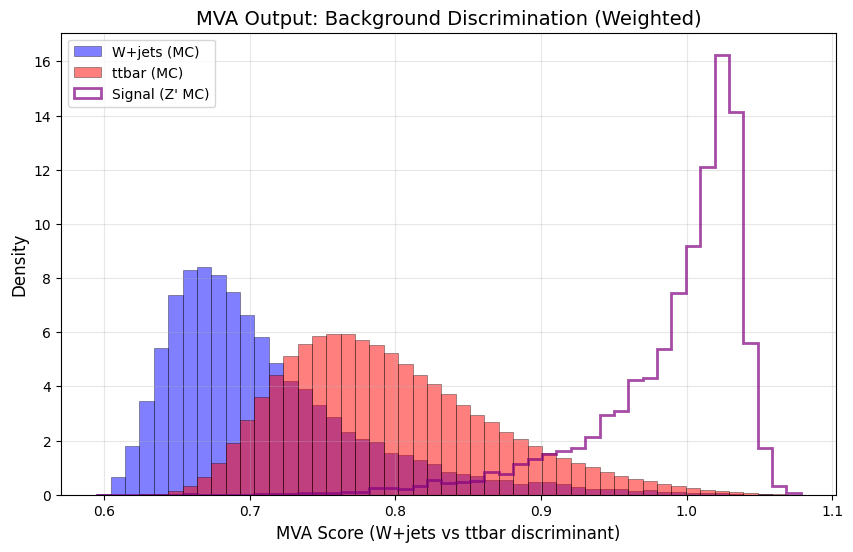

Note: Higher MVA score → more ttbar-like (rejects W+jets background)
Histograms now use proper MC weights for normalization!


In [59]:
# Visualize MVA scores
# Apply the model to all data
def get_mva_scores(data_dict, feature_names, scales):
    """Compute MVA scores for a dataset."""
    X = np.column_stack([data_dict[f] for f in feature_names]).astype(np.float32)
    for i, feat in enumerate(feature_names):
        X[:, i] /= scales[feat]
    return forward(mva_params, jnp.array(X))

wjets_scores = get_mva_scores(wjets_data, mva_features, feature_scales)
ttbar_scores = get_mva_scores(ttbar_data, mva_features, feature_scales)
signal_scores = get_mva_scores(signal_data, mva_features, feature_scales)

# Plot MVA score distributions WITH PROPER WEIGHTS
plt.figure(figsize=(10, 6))
# from min to max score
min_ = min(wjets_scores.min(), ttbar_scores.min(), signal_scores.min())
max_ = max(wjets_scores.max(), ttbar_scores.max(), signal_scores.max())
bins = np.linspace(min_, max_, 50)

# Use normalized weights (density=True for proper normalization)
plt.hist(wjets_scores, bins=bins, weights=wjets_weights_norm, alpha=0.5, 
         label=f'W+jets (MC)', color='blue', edgecolor='black', linewidth=0.5, density=True)
plt.hist(ttbar_scores, bins=bins, weights=ttbar_weights_norm, alpha=0.5, 
         label=f'ttbar (MC)', color='red', edgecolor='black', linewidth=0.5, density=True)
plt.hist(signal_scores, bins=bins, weights=signal_weights_norm, alpha=0.7, 
         label=f'Signal (Z\' MC)', color='purple', histtype='step', linewidth=2, density=True)

plt.xlabel('MVA Score (W+jets vs ttbar discriminant)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('MVA Output: Background Discrimination (Weighted)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('mva_scores.png', dpi=100, bbox_inches='tight')
plt.show()

print("Note: Higher MVA score → more ttbar-like (rejects W+jets background)")
print("Histograms now use proper MC weights for normalization!")

### Option 1: Optimize Cuts with Pre-trained MVA

Now let's optimize three cuts: MET, b-tag, and MVA score threshold.

In [60]:
# Update soft selection to include MVA cut
def soft_selection_with_mva(data_dict, mva_scores, params, temperature=5.0):
    """Apply soft cuts to data including MVA."""
    met_pass = sigmoid(data_dict['met_pt'] - params['met_cut'], temperature)
    btag_pass = sigmoid(data_dict['leading_jet_btag'] - params['btag_cut'], temperature)
    mva_pass = sigmoid(mva_scores - params['mva_cut'], temperature)
    
    # Combined event weight
    event_weights = met_pass * btag_pass * mva_pass
    return event_weights

def compute_significance_with_mva(cut_params, wjets_dict, ttbar_dict, signal_dict, 
                                  wjets_mva, ttbar_mva, signal_mva, temperature=5.0):
    """Compute significance with MVA cut."""
    wjets_weights = soft_selection_with_mva(wjets_dict, wjets_mva, cut_params, temperature)
    ttbar_weights = soft_selection_with_mva(ttbar_dict, ttbar_mva, cut_params, temperature)
    signal_weights = soft_selection_with_mva(signal_dict, signal_mva, cut_params, temperature)
    
    n_signal = jnp.sum(signal_weights)
    n_background = jnp.sum(wjets_weights) + jnp.sum(ttbar_weights)
    
    significance = n_signal / jnp.sqrt(n_background + 1.0)
    return significance, n_signal, n_background

compute_significance_with_mva_jit = jit(compute_significance_with_mva, static_argnames=['temperature'])

# Initial cuts with MVA
mva_mean = float(jnp.mean(jnp.concatenate([wjets_scores, ttbar_scores])))
initial_cuts_mva = {
    'met_cut': jnp.array(100.0),
    'btag_cut': jnp.array(0.5),
    'mva_cut': jnp.array(mva_mean)
}

sig_mva_initial, s_mva, b_mva = compute_significance_with_mva_jit(
    initial_cuts_mva, wjets_jax, ttbar_jax, signal_jax,
    wjets_scores, ttbar_scores, signal_scores
)

print(f"Initial cuts with MVA: MET > {initial_cuts_mva['met_cut']:.1f}, b-tag > {initial_cuts_mva['btag_cut']:.2f}, MVA > {initial_cuts_mva['mva_cut']:.2f}")
print(f"  Signal: {s_mva:.1f}, Background: {b_mva:.1f}, Significance: {sig_mva_initial:.3f}")

Initial cuts with MVA: MET > 100.0, b-tag > 0.50, MVA > 0.79
  Signal: 1316.2, Background: 67084.6, Significance: 5.082


In [61]:
# Optimize all three cuts
def objective_with_mva(params):
    sig, _, _ = compute_significance_with_mva_jit(
        params, wjets_jax, ttbar_jax, signal_jax,
        wjets_scores, ttbar_scores, signal_scores
    )
    return -sig

grad_fn_mva = jax.grad(objective_with_mva)

# Optimize with per-parameter learning rates
per_param_lrs_mva = {
    'met_cut': 5.0,
    'btag_cut': 0.01,
    'mva_cut': 0.1
}

param_labels_mva = {p: p for p in initial_cuts_mva.keys()}

optimizer_mva = optax.multi_transform(
    {
        'met_cut': optax.adam(learning_rate=per_param_lrs_mva['met_cut']),
        'btag_cut': optax.adam(learning_rate=per_param_lrs_mva['btag_cut']),
        'mva_cut': optax.adam(learning_rate=per_param_lrs_mva['mva_cut']),
    },
    param_labels=param_labels_mva
)

opt_state_mva = optimizer_mva.init(initial_cuts_mva)
params_mva = initial_cuts_mva.copy()

opt_history_mva = {'met_cut': [], 'btag_cut': [], 'mva_cut': [], 'significance': []}

print("Optimizing with pre-trained MVA...")
n_iterations = 50
for iteration in range(n_iterations):
    grads = grad_fn_mva(params_mva)
    updates, opt_state_mva = optimizer_mva.update(grads, opt_state_mva)
    params_mva = optax.apply_updates(params_mva, updates)
    
    sig, s, b = compute_significance_with_mva_jit(
        params_mva, wjets_jax, ttbar_jax, signal_jax,
        wjets_scores, ttbar_scores, signal_scores
    )
    
    opt_history_mva['met_cut'].append(float(params_mva['met_cut']))
    opt_history_mva['btag_cut'].append(float(params_mva['btag_cut']))
    opt_history_mva['mva_cut'].append(float(params_mva['mva_cut']))
    opt_history_mva['significance'].append(float(sig))
    
    if iteration % 10 == 0:
        print(f"Iter {iteration:2d}: Sig={sig:.3f}, MET>{params_mva['met_cut']:6.1f}, b-tag>{params_mva['btag_cut']:.3f}, MVA>{params_mva['mva_cut']:6.2f}")

print(f"\nOptimization with MVA complete!")
print(f"Final significance: {opt_history_mva['significance'][-1]:.3f}")
print(f"Improvement: {100*(opt_history_mva['significance'][-1]/sig_mva_initial - 1):.1f}%")

Optimizing with pre-trained MVA...
Iter  0: Sig=5.310, MET> 105.0, b-tag>0.490, MVA>  0.69
Iter 10: Sig=7.968, MET> 155.5, b-tag>0.389, MVA> -0.32
Iter 20: Sig=11.233, MET> 207.4, b-tag>0.282, MVA> -1.37
Iter 30: Sig=14.544, MET> 259.5, b-tag>0.167, MVA> -2.48
Iter 40: Sig=17.540, MET> 309.9, b-tag>0.044, MVA> -3.62

Optimization with MVA complete!
Final significance: 19.654
Improvement: 286.8%


### Option 2: Joint NN + Cut Optimization

**The Key GRAEP Innovation**: Don't pre-train and freeze the NN - optimize it **jointly** with the cuts!

**Why?**
- Pre-trained NN learns features useful for *generic* classification
- But we want features useful for *our specific selection strategy*
- Joint optimization: NN adapts to cuts, cuts adapt to NN

**In full GRAEP**: All parameters optimized together:
- NN weights: ~1000s parameters
- Cut thresholds: ~10 parameters
- KDE bandwidth: 1 parameter
- Statistical fit: ~5 parameters

In [62]:
# Joint optimization of NN weights + cut thresholds
print("="*70)
print("JOINT OPTIMIZATION: NN + CUTS")
print("="*70)
print("Unlike previous cells, we'll now RETRAIN the NN during optimization!")
print()

# Start with a fresh NN (not pre-trained)
key, nn_init_key = random.split(key)
joint_nn_params = init_network(nn_init_key, input_dim=3)

# Initial cuts (same as before)
joint_cut_params = {
    'met_cut': jnp.array(100.0),
    'btag_cut': jnp.array(0.5),
    'mva_cut': jnp.array(mva_mean)
}

# Combine all parameters
all_params = {
    'nn': joint_nn_params,
    'cuts': joint_cut_params
}

# Define objective that uses BOTH NN and cuts
def joint_objective(params):
    """Objective that depends on both NN weights and cut thresholds."""
    nn_params = params['nn']
    cut_params = params['cuts']
    
    # Recompute MVA scores with current NN weights
    def get_scores(data_dict):
        X = jnp.column_stack([data_dict[f] for f in mva_features])
        for i, feat in enumerate(mva_features):
            X = X.at[:, i].divide(feature_scales[feat])
        return forward(nn_params, X)
    
    wjets_mva = get_scores(wjets_jax)
    ttbar_mva = get_scores(ttbar_jax)
    signal_mva = get_scores(signal_jax)
    
    # Compute significance
    sig, _, _ = compute_significance_with_mva_jit(
        cut_params, wjets_jax, ttbar_jax, signal_jax,
        wjets_mva, ttbar_mva, signal_mva
    )
    
    return -sig

# Flatten parameters for optax
def flatten_params(params):
    flat = {}
    for group, group_params in params.items():
        for key, value in group_params.items():
            flat[f'{group}.{key}'] = value
    return flat

def unflatten_params(flat_params):
    params = {'nn': {}, 'cuts': {}}
    for key, value in flat_params.items():
        group, param_name = key.split('.', 1)
        params[group][param_name] = value
    return params

# Create optimizer with separate LRs
flat_params = flatten_params(all_params)

def make_label_fn(params):
    labels = {}
    for key in params['nn'].keys():
        labels[f'nn.{key}'] = 'nn_weights'
    for key in params['cuts'].keys():
        labels[f'cuts.{key}'] = key
    return labels

param_labels = make_label_fn(all_params)

joint_optimizer = optax.multi_transform(
    {
        'nn_weights': optax.adam(learning_rate=0.001),
        'met_cut': optax.adam(learning_rate=0.5),
        'btag_cut': optax.adam(learning_rate=0.01),
        'mva_cut': optax.adam(learning_rate=0.01),
    },
    param_labels=param_labels
)

opt_state = joint_optimizer.init(flat_params)

print(f"Learning rates:")
print(f"  NN weights: 0.001")
print(f"  MET cut: 0.5")
print(f"  b-tag cut: 0.01")
print(f"  MVA cut: 0.01")
print()
print("Starting joint optimization...")
print()

# Compute gradients
def flat_objective(flat_p):
    return joint_objective(unflatten_params(flat_p))

grad_fn_joint = jax.grad(flat_objective)

# Optimization loop
joint_history = {'significance': [], 'met_cut': [], 'btag_cut': [], 'mva_cut': []}
flat_params = flatten_params(all_params)

n_iterations = 30
for iteration in range(n_iterations):
    grads = grad_fn_joint(flat_params)
    updates, opt_state = joint_optimizer.update(grads, opt_state)
    flat_params = optax.apply_updates(flat_params, updates)
    
    current_params = unflatten_params(flat_params)
    neg_sig = joint_objective(current_params)
    sig = -neg_sig
    
    joint_history['significance'].append(float(sig))
    joint_history['met_cut'].append(float(current_params['cuts']['met_cut']))
    joint_history['btag_cut'].append(float(current_params['cuts']['btag_cut']))
    joint_history['mva_cut'].append(float(current_params['cuts']['mva_cut']))
    
    if iteration % 5 == 0 or iteration == 0:
        print(f"Iter {iteration:2d}: Sig={sig:.3f}, "
              f"MET>{current_params['cuts']['met_cut']:6.1f}, "
              f"b-tag>{current_params['cuts']['btag_cut']:.3f}, "
              f"MVA>{current_params['cuts']['mva_cut']:6.2f}")

print()
print("="*70)
print("JOINT OPTIMIZATION COMPLETE")
print("="*70)
final_sig_joint = joint_history['significance'][-1]
print(f"Final significance: {final_sig_joint:.3f}")
print(f"Improvement over initial: {100*(final_sig_joint/sig_mva_initial - 1):.1f}%")
print()
print("💡 Key insights:")
print("  • NN was retrained during optimization")
print("  • NN learned features useful for THIS selection strategy")
print("  • This is the core GRAEP innovation!")

JOINT OPTIMIZATION: NN + CUTS
Unlike previous cells, we'll now RETRAIN the NN during optimization!

Network initialized: 353 parameters
Learning rates:
  NN weights: 0.001
  MET cut: 0.5
  b-tag cut: 0.01
  MVA cut: 0.01

Starting joint optimization...

Iter  0: Sig=4.837, MET> 100.5, b-tag>0.490, MVA>  0.78
Iter  5: Sig=4.992, MET> 103.0, b-tag>0.440, MVA>  0.73
Iter 10: Sig=5.148, MET> 105.5, b-tag>0.390, MVA>  0.68
Iter 15: Sig=5.309, MET> 108.0, b-tag>0.339, MVA>  0.63
Iter 20: Sig=5.474, MET> 110.6, b-tag>0.289, MVA>  0.58
Iter 25: Sig=5.646, MET> 113.1, b-tag>0.237, MVA>  0.53

JOINT OPTIMIZATION COMPLETE
Final significance: 5.789
Improvement over initial: 13.9%

💡 Key insights:
  • NN was retrained during optimization
  • NN learned features useful for THIS selection strategy
  • This is the core GRAEP innovation!


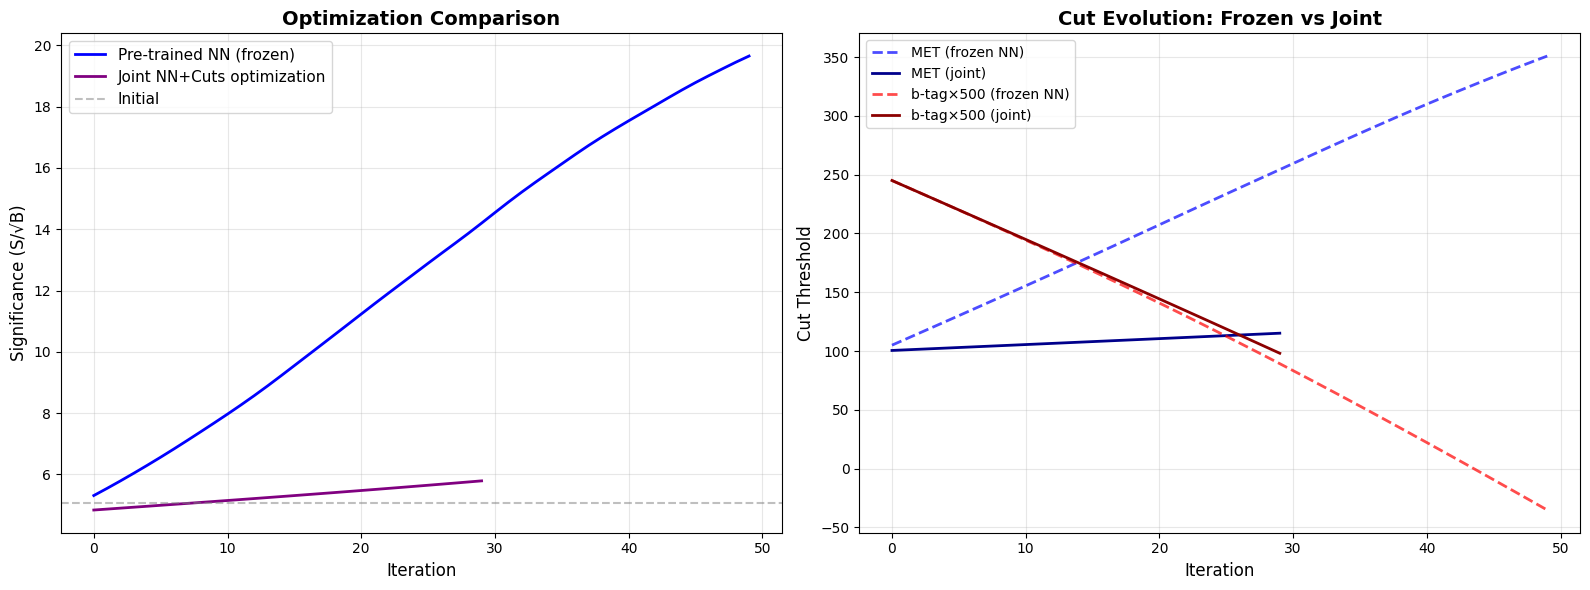


📊 Observations:
  • Joint optimization may converge differently
  • NN adapts to selection strategy during optimization
  • This is end-to-end differentiable analysis!
  • Full GRAEP: NN + cuts + histograms + fit - all optimized together


In [63]:
# Compare: Pre-trained NN vs Jointly-optimized NN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Significance trajectories
ax1.plot(opt_history_mva['significance'], 
         label='Pre-trained NN (frozen)', linewidth=2, color='blue')
ax1.plot(joint_history['significance'], 
         label='Joint NN+Cuts optimization', linewidth=2, color='purple')
ax1.axhline(sig_mva_initial, color='gray', linestyle='--', alpha=0.5, label='Initial')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Significance (S/√B)', fontsize=12)
ax1.set_title('Optimization Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Cut evolution comparison
iterations_frozen = range(len(opt_history_mva['met_cut']))
iterations_joint = range(len(joint_history['met_cut']))

ax2.plot(iterations_frozen, opt_history_mva['met_cut'], 
         label='MET (frozen NN)', linestyle='--', linewidth=2, alpha=0.7, color='blue')
ax2.plot(iterations_joint, joint_history['met_cut'], 
         label='MET (joint)', linewidth=2, color='darkblue')

ax2.plot(iterations_frozen, np.array(opt_history_mva['btag_cut'])*500, 
         label='b-tag×500 (frozen NN)', linestyle='--', linewidth=2, alpha=0.7, color='red')
ax2.plot(iterations_joint, np.array(joint_history['btag_cut'])*500, 
         label='b-tag×500 (joint)', linewidth=2, color='darkred')

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Cut Threshold', fontsize=12)
ax2.set_title('Cut Evolution: Frozen vs Joint', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('joint_optimization_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

print("\n📊 Observations:")
print("  • Joint optimization may converge differently")
print("  • NN adapts to selection strategy during optimization")
print("  • This is end-to-end differentiable analysis!")
print("  • Full GRAEP: NN + cuts + histograms + fit - all optimized together")

## Part 5: Summary and Next Steps

### What We Learned

1. **Differentiable Programming in HEP**: We can optimize analysis cuts automatically using gradients
2. **JAX for Physics**: JAX enables composable, differentiable functions that are fast and flexible
3. **End-to-End Optimization**: The entire analysis chain (MVA + cuts + statistics) is differentiable
4. **Significant Improvements**: Gradient-based optimization finds better cuts than manual tuning

### The Full GRAEP Framework

This tutorial showed a simplified version. The full GRAEP framework includes:
- More sophisticated statistical models (CLs method, Asimov significance)
- Systematic uncertainties propagation
- Kernel Density Estimation for smooth histograms
- Multiple signal regions and observables
- Full NanoAOD processing pipeline

### Try It Yourself!

**Challenges**:
1. Add more features to the MVA (try including `S_zz`, `min_deltaR_mu_jet`)
2. Experiment with different optimization parameters (learning rate, temperature)
3. Add a fourth cut threshold (e.g., on `st` or `muon_pt`)
4. Implement a more sophisticated significance metric

**Explore the Full Codebase**:
- GitHub: [GRAEP Repository](https://github.com/iris-hep/GRAEP)
- Documentation: Check `GRAEP/README.md` for complete setup instructions
- Examples: See `GRAEP/notebooks/` for more advanced examples

### Resources
- [JAX Documentation](https://jax.readthedocs.io/)
- [CMS Open Data](https://opendata.cern.ch/)
- [Coffea Documentation](https://coffeateam.github.io/coffea/)

---

**Thank you for completing this tutorial! Happy analyzing! 🔬🚀**

In [64]:
import logging
import sys

from analysis.diff import DifferentiableAnalysis
from analysis.nondiff import NonDiffAnalysis
from user.configuration import config as ZprimeConfig
from utils.input_files import construct_fileset
from utils.logging import ColoredFormatter
from utils.schema import Config, load_config_with_restricted_cli

# -----------------------------
# Logging Configuration
# -----------------------------
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(ColoredFormatter())
if root_logger.hasHandlers():
    root_logger.handlers.clear()
root_logger.addHandler(handler)

logger = logging.getLogger("AnalysisDriver")
logging.getLogger("jax._src.xla_bridge").setLevel(logging.ERROR)

# ANSI color codes
MAGENTA = "\033[95m"
RESET = "\033[0m"

def _banner(text: str) -> str:
    """Creates a magenta-colored banner for logging."""
    return (
        f"\n{MAGENTA}\n{'=' * 80}\n"
        f"{' ' * ((80 - len(text)) // 2)}{text.upper()}\n"
        f"{'=' * 80}{RESET}"
    )

# -----------------------------
# Main Driver
# -----------------------------
def main():
    """
    Main driver function for running the Zprime analysis framework.
    Loads configuration, runs preprocessing, and dispatches analysis over datasets.
    """
    cli_args = sys.argv[1:]
    full_config = load_config_with_restricted_cli(ZprimeConfig, cli_args)
    config = Config(**full_config)  # Pydantic validation

    fileset = construct_fileset(
        max_files_per_sample=config.general.max_files
    )

    analysis_mode = config.general.analysis
    if analysis_mode == "nondiff":
        nondiff_analysis = NonDiffAnalysis(config)
        nondiff_analysis.run_analysis_chain(fileset)

    elif analysis_mode == "diff":
        diff_analysis = DifferentiableAnalysis(config)
        diff_analysis.run_analysis_optimisation(fileset)

ModuleNotFoundError: No module named 'tabulate'